In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [165]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.94 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [166]:
data, all_gdps, all_gts = load_data()

In [167]:
data_preprocessed = []
search_terms = [col for col in all_gts.columns if col.endswith('_average')]
data.sort_values(by=['date', 'country'], inplace=True)
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')
data_copied = data.copy()
data_copied['date'] = pd.to_datetime(data_copied['date'])


### Data 1. Direct Google Trends Data

In [168]:
#data_preprocessed.append(data)

### Data 2. Google Trends Data with Lagged Values

In [169]:
NB_PAST_QUARTERS = 8

processed_gts = all_gts.copy()
processed_gts['date'] = pd.to_datetime(processed_gts['date'])

# Take the log of the search terms
processed_gts[search_terms] = np.log(processed_gts[search_terms] + 1)

# Add the difference of log search terms current - current-1Q, current - current-2Q, etc.
for nb_quarters in range(1, NB_PAST_QUARTERS + 1):
    diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(3 * nb_quarters)).add_prefix(f'q{nb_quarters}-')
    processed_gts = pd.concat([processed_gts, diff], axis=1)

# Drop the current values as they are already in data
processed_gts.drop(columns=search_terms, inplace=True)

print(f"Data shape: {data.shape}")

processed_gts = processed_gts.dropna()
data_merged = data_copied.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')
data_merged.dropna(inplace=True)
data_preprocessed.append(data_merged)

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (502, 849)


### Data 3. Google Trends Data with average values

In [170]:
NB_PAST_QUARTERS = 8

processed_gts = all_gts.copy()
processed_gts['date'] = pd.to_datetime(processed_gts['date'])

# Add gts from 1 year ago (ok because we sort by date then by country)
processed_gts = pd.concat([processed_gts[['country', 'date']], processed_gts[search_terms].shift(12).add_prefix('1yo_old_')], axis=1)

# Add the average of the search terms over the past 4 quarters
rolling_result = all_gts.groupby('country')[search_terms + ['date']].rolling(4).mean(numeric_only=True).reset_index()
rolling_result['date'] = all_gts.loc[rolling_result['level_1'], 'date'].values
rolling_result = rolling_result.drop(columns='level_1')
rolling_result.sort_values(by=['country', 'date'], inplace=True)
processed_gts = pd.concat([processed_gts, rolling_result[search_terms].add_prefix('1yo_avg_')], axis=1)

print(f"Data shape: {data.shape}")

processed_gts = processed_gts.dropna()
data_merged = data_copied.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')
data_merged.dropna(inplace=True)
data_preprocessed.append(data_merged)

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (541, 285)


### Preprocess all data

In [171]:
splitting_date = data_copied['date'].quantile(TRAIN_PROPORTION)
splitting_date

Timestamp('2022-12-01 00:00:00')

In [172]:
all_preprocessed = []
for dataset in data_preprocessed:
    preprocessor = Preprocessing(data=dataset, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
    X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, splitting_date=splitting_date)
    all_preprocessed.append((X_train.values, y_train.values, X_valid.values, y_valid.values, preprocessor))


X_train shape : (435, 856)
X_valid shape : (39, 856)
y_train shape : (435,)
y_valid shape : (39,)
X_train shape : (474, 292)
X_valid shape : (39, 292)
y_train shape : (474,)
y_valid shape : (39,)


## Simple Prediction Model

### We start with a simple regression model

In [173]:
x_train = X_train.values
x_valid = X_valid.values
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

In [174]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [175]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-3, seed=42, verbose=True):
    set_seed(seed)

    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []

    training_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    
    for t in training_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, training_loss, validation_loss

In [177]:
trained_models = []
seeds = range(123, 223)

for seed in seeds:
    for x_train, y_train, x_valid, y_valid, preprocessor in all_preprocessed:
        model, training_loss, validation_loss = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=40, learning_rate=1e-3, weight_decay=1e-4, seed=seed, verbose=False)

        # Get the predictions
        x_valid_for_pred = torch.tensor(x_valid, dtype=torch.float32).to(device)
        x_train_for_pred = torch.tensor(x_train, dtype=torch.float32).to(device)
        y_pred = model(x_valid_for_pred).clone().detach().cpu().numpy().squeeze()
        y_pred_train = model(x_train_for_pred).clone().detach().cpu().numpy().squeeze()

        trained_models.append((model, training_loss, validation_loss, y_pred, y_pred_train, preprocessor))

Validation loss: 0.7634821534156799
Validation loss: 1.5928815603256226
Validation loss: 1.3388922214508057
Validation loss: 1.725915789604187
Validation loss: 1.3885313272476196
Validation loss: 1.6666808128356934
Validation loss: 1.0751473903656006
Validation loss: 1.596774697303772
Validation loss: 1.6149301528930664
Validation loss: 1.4215596914291382
Validation loss: 0.9036959409713745
Validation loss: 1.737412691116333
Validation loss: 1.159775733947754
Validation loss: 1.6704274415969849
Validation loss: 1.1869217157363892
Validation loss: 1.3248459100723267
Validation loss: 1.1408045291900635
Validation loss: 1.3019533157348633
Validation loss: 1.115118145942688
Validation loss: 1.2916942834854126
Validation loss: 0.7842544317245483
Validation loss: 1.72420072555542
Validation loss: 0.9995582103729248
Validation loss: 1.4877550601959229
Validation loss: 0.8449859619140625
Validation loss: 1.3247743844985962
Validation loss: 0.9310879707336426
Validation loss: 1.2759768962860107

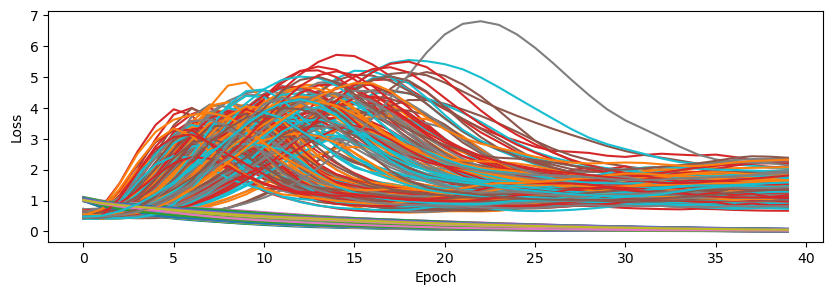

In [178]:
plt.figure(figsize=(10, 3))
for i, (model, training_loss, validation_loss, y_pred, y_pred_train, preprocessor) in enumerate(trained_models):
    plt.plot(training_loss, label=f"Training loss {i}")
    plt.plot(validation_loss, label=f"Validation loss {i}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [179]:
y_pred_train_shapes = [y_pred_train.shape[0] for _, _, _, _, y_pred_train, _ in trained_models]
min_elems_y_pred_train = np.min(y_pred_train_shapes)

In [180]:
# Collect all predictions for validation and training sets
y_pred_valid_all = np.array([y_pred for _, _, _, y_pred, _, _ in trained_models])
y_pred_train_all = np.array([y_pred_train[-min_elems_y_pred_train:] for _, _, _, _, y_pred_train, _ in trained_models])


In [181]:
# Compute mean predictions
y_pred_valid_mean = np.mean(y_pred_valid_all, axis=0)
y_pred_train_mean = np.mean(y_pred_train_all, axis=0)

# Compute standard deviations
y_pred_valid_std = np.std(y_pred_valid_all, axis=0)
y_pred_train_std = np.std(y_pred_train_all, axis=0)

# Compute 95% prediction intervals
y_pred_valid_lower = np.percentile(y_pred_valid_all, 2.5, axis=0)
y_pred_valid_upper = np.percentile(y_pred_valid_all, 97.5, axis=0)

y_pred_train_lower = np.percentile(y_pred_train_all, 2.5, axis=0)
y_pred_train_upper = np.percentile(y_pred_train_all, 97.5, axis=0)


In [182]:
# Compute loss
mean_squared_error(y_valid, y_pred_valid_mean)

0.9672680856983266

In [183]:
# For validation set
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': country_valid,
    'y_pred_mean': y_pred_valid_mean,
    'y_pred_lower': y_pred_valid_lower,
    'y_pred_upper': y_pred_valid_upper,
    'y_true': y_valid
})

# For training set
y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train[-min_elems_y_pred_train:],
    'country': country_train[-min_elems_y_pred_train:],
    'y_pred_mean': y_pred_train_mean,
    'y_pred_lower': y_pred_train_lower,
    'y_pred_upper': y_pred_train_upper,
    'y_true': y_train[-min_elems_y_pred_train:]
})

# Combine the predictions
predictions = pd.concat([y_pred_train_country, y_pred_country])


In [184]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [185]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    filtered_data = filtered_data.sort_values(by='date')
    cutoff_date = splitting_date
    plt.figure(figsize=(12, 6))
    
    # Plot the true values
    plt.plot(filtered_data['date'], filtered_data['y_true'], label='True Values', color='blue')
    
    # Plot the predicted mean
    plt.plot(filtered_data['date'], filtered_data['y_pred_mean'], label='Predicted Mean', color='orange')
    
    # Add the prediction interval
    plt.fill_between(
        filtered_data['date'],
        filtered_data['y_pred_lower'],
        filtered_data['y_pred_upper'],
        color='orange', alpha=0.2, label='95% Prediction Interval'
    )
    
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('United States', 'United Kingdom', 'Switzerlan…

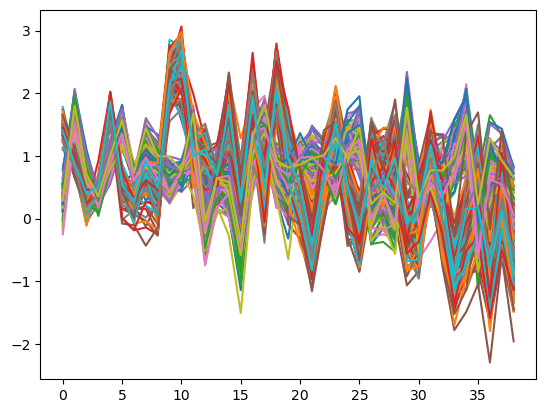

In [187]:
for i, (model, training_loss, validation_loss, y_pred, y_pred_train, preprocessor) in enumerate(trained_models):
    plt.plot(y_pred)